## Spam Classification

In this project we used text classification to determined whether the messages is spam or not. We used NLP methods to prepare and clean our text data (tokenization, remove stop words, stemming) and different machine learning algorithms to get more accurate predictions. The following classification algorithms have been used: Logistic Regression, Naive Bayes, Support Vector Machine (SVM), Random Forest, Stochastic Gradient Descent and Gradient Boosting.

### Dataset
The dataset comes from SMS Spam Collection that can be find at https://www.kaggle.com/uciml/sms-spam-collection-dataset. 

This SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It comprises one set of SMS messages in English of 5,574 messages, which is tagged acording being ham (legitimate) or spam. 


In [2]:
import numpy as np
import random
import tensorflow as tf
from sklearn.utils import shuffle

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


### Loading libaries and data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


spam = pd.read_csv("C:/Users/anish/Desktop/Capstone Project/spam.csv", encoding='latin-1')
spam.head()

In [6]:
spam = pd.read_csv("C:/Users/anish/Desktop/Capstone Project/spam.csv", encoding="ISO-8859-1")
spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


First observations:

In [8]:
spam.shape

(5572, 5)

In [9]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


We have 86 961 words in the data:

In [11]:
print(spam['v2'].apply(lambda x: len(x.split(' '))).sum())

86961


### Data cleaning

Remove unnecessary variables:

In [13]:
spam.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [14]:
spam.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Rename columns:

In [16]:
spam.rename(columns={'v1': 'Class', 'v2': 'Text'}, inplace=True)
spam.head()

,Class,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


We change column "Class" to 0 and 1:

- spam = 1
- ham = 0

In [18]:
spam['Class'] = spam['Class'].map({'ham':0, 'spam':1})
spam.head()

,Class,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
spam['Text'][1]

'Ok lar... Joking wif u oni...'

In [20]:
spam['Text'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

### Basic EDA

We check proportion Class variable:

In [22]:
spam['Class'].value_counts()

Class
0    4825
1     747
Name: count, dtype: int64

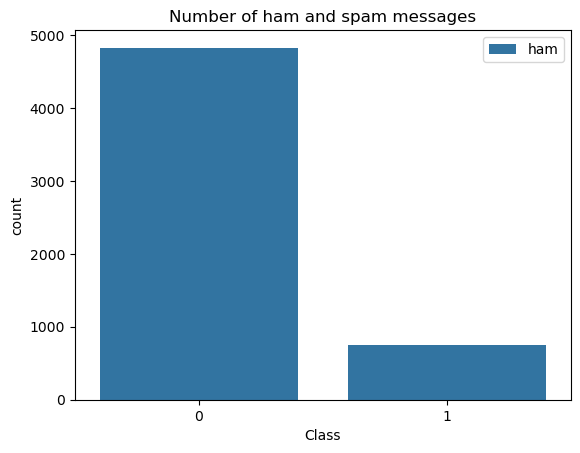

In [23]:
sns.countplot(x='Class',data=spam)
plt.xlabel('Class')
plt.title('Number of ham and spam messages')
plt.legend(labels=['ham', 'spam']);

The target class variable is imbalanced, where "ham" values are more dominating than "spam".

In [25]:
spam.describe()

,Class
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Length of text messages:

In [27]:
spam['length'] = spam.Text.apply(len)
spam.head()

,Class,Text,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


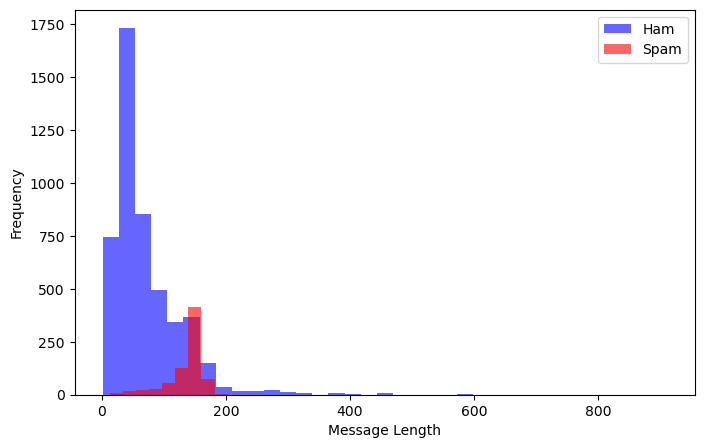

In [28]:
plt.figure(figsize=(8, 5))
spam[spam.Class == 0].length.plot(bins=35, kind='hist', color='blue', label='Ham', alpha=0.6)
spam[spam.Class == 1].length.plot(kind='hist', color='red', label='Spam', alpha=0.6)
plt.legend()
plt.xlabel("Message Length");

In [29]:
import nltk

### Text Pre-processing

In the next step we clean text, remove stop words and apply stemming operation for each line of text:

In [31]:
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [32]:
def preprocess_text(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                   
    return " ".join(text)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)


In [33]:
spam['Text'] = spam['Text'].apply(clean_text)
spam.head()

,Class,Text,length
0,0,go until jurong point crazy available only in ...,111
1,0,ok lar joking wif u oni,29
2,1,free entry in a wkly comp to win fa cup final ...,155
3,0,u dun say so early hor u c already then say,49
4,0,nah i don t think he goes to usf he lives arou...,61


In [34]:
spam['Text'] = spam['Text'].apply(remove_stopwords)
spam['Text'] = spam['Text'].apply(stemmer)

In [35]:
spam.head()

,Class,Text,length
0,0,go jurong point crazi avail bugi n great world...,111
1,0,ok lar joke wif u oni,29
2,1,free entri wkli comp win fa cup final tkt st m...,155
3,0,u dun say earli hor u c alreadi say,49
4,0,nah think goe usf live around though,61


In [36]:
print(spam['Text'].apply(lambda x: len(x.split(' '))).sum())

49940


In [37]:
#save clean data
spam.to_csv("C:/Users/anish/Desktop/Capstone Project/spam_clean.csv")

In [38]:
spam_clean=pd.read_csv("C:/Users/anish/Desktop/Capstone Project/spam_clean.csv")

After text cleaning and removing stop words, we have only 49 940 words.

In [40]:
# MILESTONE 2

### Vectorization

To run machine learning algorithms we need to convert text files into numerical feature vectors. 

First we spliting the data into X and y values:

In [42]:
X = spam['Text']
y = spam['Class']

In [43]:
vect = TfidfVectorizer(min_df=5, ngram_range=(1, 4)).fit(X)
X_tfidf = vect.transform(X)
print(len(vect.get_feature_names_out()))


2856


In [44]:
print(len(X), len(y))


5572 5572


Now, we create a numerical feature vector for each document:

We spliting the data into train and test sets:

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state = 0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)


print(y_test.shape)

(4457, 2856)
(1115, 2856)
(4457,)
(1115,)


**SMOTE**

The target class variable is imbalanced, "ham" values are more dominating than "spam". 
The simplest way to improve imbalanced dataset is balancing them by oversampling instances of the minority class or undersampling instances of the majority class. We will try to balancing classes by using one of the advanced techniques like the SMOTE method (Synthetic Minority Over-sampling Technique).

SMOTE technique  is one of the most commonly used oversampling methods to solve the imbalance problem. It goal is to balance class distribution by randomly increasing  minority class examples by replicating them.  

We will use imbalanced-learn library to apply SMOTE method:

In [49]:
smote = SMOTE()
X_train_sm,y_train_sm = smote.fit_resample(X_train,y_train)

In [50]:
print(X_train_sm.shape)
print(y_train_sm.shape)

(7752, 2856)
(7752,)


In [51]:
# MILESTONE 3

### Building models

We use the following classification models:

- Logistic Regression,
- Naive Bayes Classifier,
- Random Forest Classifier,
- Gradient Boosting,
- SVM (Support Vector Machine),
- Stochastic Gradient Descent.

To make the vectorizer => transformer => classifier easier to work with, we will use Pipeline class in Scilkit-Learn.


**Logistic regression**

In [53]:
model_lr = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',LogisticRegression()),
                   ])

model_lr.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
pred_y = model_lr.predict(X_test)

In [54]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.9856502242152466
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       949
           1       0.98      0.92      0.95       166

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



**Naive Bayes:**

In [56]:
model_nb = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',MultinomialNB()),
                   ])

model_nb.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
pred = model_nb.predict(X_test)

In [57]:
print('accuracy %s' % accuracy_score(pred, y_test))
print(classification_report(ytest, pred))

accuracy 0.979372197309417
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       949
           1       0.94      0.92      0.93       166

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



**Random Forest Classifier**

In [59]:
model_rf = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',RandomForestClassifier(n_estimators=50)),
                   ])

model_rf.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
preds = model_rf.predict(X_test)

In [60]:
print('accuracy %s' % accuracy_score(preds, y_test))
print(classification_report(ytest, preds))

accuracy 0.9820627802690582
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       949
           1       0.99      0.89      0.94       166

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



**Gradient Boosting**

In [ ]:
model_gb = Pipeline([('tfidf', TfidfTransformer()),
                    ('model', GradientBoostingClassifier(random_state=100, n_estimators=150,min_samples_split=100, max_depth=6)),
                    ])

model_gb.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
y_pred = model_gb.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(ytest, y_pred))

**Support Vector Machine**

In [ ]:
model_svc = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',LinearSVC()),
                     ])

model_svc.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
predict = model_svc.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(predict, y_test))
print(classification_report(ytest, predict))

**Stochastic Gradient Descent**

In [ ]:
model_sg = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',SGDClassifier()),
                     ])

model_sg.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
predicted = model_sg.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(predicted, y_test))
print(classification_report(ytest, predicted))

In [ ]:
# MILESTONE 4

**Best model**

We tested six different models and now, we check which one is the best:

In [ ]:
log_acc = accuracy_score(pred_y, y_test)
nb_acc = accuracy_score(pred, y_test)
rf_acc = accuracy_score(preds, y_test)
gb_acc = accuracy_score(y_pred, y_test)
svm_acc = accuracy_score(predict, y_test)
sg_acc = accuracy_score(predicted, y_test)

In [ ]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'Gradient Boosting', 'SVM', 'SGD'],
                      'Score': [log_acc, nb_acc, rf_acc, gb_acc, svm_acc, sg_acc]})
models.sort_values(by='Score', ascending=False)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(model, X_test, y_test, model_name, ax):
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    
    # Store metrics in a dictionary
    metrics[model_name] = {
        'Confusion Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }
    
    # Print metrics
    print(f"Results for {model_name}:\n")
    print(classification_report(y_test, y_pred))
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)
    ax.set_title(f"Confusion Matrix for {model_name}")

# Assuming you have already defined your models
models = [
    ('Stochastic Gradient Descent', model_sg),
    ('Random Forest', model_rf),
    ('Naive Bayes', model_nb),
    ('Logistic Regression', model_lr),
    ('Gradient Boosting', model_gb),
    ('Support Vector Classifier', model_svc)
]

# Initialize dictionary to store metrics
metrics = {}

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

# Evaluate each model
for idx, (model_name, model) in enumerate(models):
    evaluate_model(model, X_test, y_test, model_name, axs[idx])

# Adjust layout
plt.tight_layout()
plt.show()

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame.from_dict(metrics, orient='index')

# Print the summary table
print("Summary of Model Metrics:\n")
print(metrics_df)

# Identify the model with the highest recall
best_model_name = metrics_df['Recall'].idxmax()
best_model_recall = metrics_df['Recall'].max()

print(f"\nThe best model with the highest recall is {best_model_name} with a recall of {best_model_recall}.")


### Conclusion

This project was aimed to text classification to determined whether the messages is spam or not. We started with the dcleaning and text mining, which cover change text into tokens, remove punctuation, stop words and normalization them by stemming. Following we used bag of words model to convert the text into numerical feature vectors. Finally we started training six different classification models and we got the best accuracy of 0.98 and best recall of 0.96 for Logistic Regression method.


In [ ]:
import pickle
with open('lr.pkl', 'wb') as model_file:
    pickle.dump(model_lr, model_file)


In [ ]:


# Assume vect is your CountVectorizer fitted on the training data
def clean_text(text):
    words = re.sub("[^a-zA-Z]", " ", text)
    text = words.lower().split()
    return " ".join(text)

def remove_stopwords(text):
    stop_words = stopwords.words('english')
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    porter = PorterStemmer()
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

def preprocess_text(text):
    clean = clean_text(text)
    no_stop = remove_stopwords(clean)
    stemmed = stemmer(no_stop)
    return stemmed

def predict_spam(text):
    processed_text = preprocess_text(text)
    vectorized_text = vect.transform([processed_text])
    prediction = model_lr.predict(vectorized_text)
    return "Spam" if prediction == 1 else "Ham"

# Example usage
text = "Congratulations! You've won a free ticket to Bahamas. Call now!"
print(predict_spam(text))


In [ ]:
text = "Hi Dave! Meet up at 6?"
print(predict_spam(text))

In [ ]:
text = "SDMTXT: Summer made easy. Get ready for the long weekend with our Summer SMS Contest! Reply SUN to enter. Weekly prizes will be announced through mobile msgs until June 11! Click to learn more: shoppersdrugmart.ca/smscontest StdMsg&DataRatesApply. STOP=stopHELP=help"
print(predict_spam(text))

In [ ]:
text = "Canada Post: Your package arrived at the warehouse but could not be delivered due to incomplete address information. Please confirm your address in the link.https://canadapost.pctfur.top/Posst(Please reply Y, then exit the text message and open it again to activate the link, or copy the link and open it in your Safari browser)"
print(predict_spam(text))

In [ ]:
text = "lNTERAC e-Transfer : Canada Revenue Agency has sent CAN279.83 Please visit here to claim your HST / GST payment return:https://govcanadarevenuetaxreturn.com"
print(predict_spam(text))

In [ ]:
text  = "Freedom Mobile Billing Alert: Your latest bill is now available. The current balance is $149.61 due by: May 19. To make a payment or review your bill, please visit us at https://frdm.mobi/myacct. For worry-free payments, set up AutoPay any time by logging in to MyAccount."
print(predict_spam(text))

In [ ]:
text = "hi mary !, how are you doing?"
print(predict_spam(text))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

# Example training data
ham_texts = [
    "Hi Mary! How are you doing?", 
    "Don't forget about our meeting tomorrow at 10 AM.", 
    "Can you send me the report by end of the day?"
]
spam_texts = [
    "Congratulations! You've won a free iPhone! Click here to claim your prize.", 
    "Limited time offer: Buy one, get one free! Hurry, offer ends soon!"
]

# Labels
texts = ham_texts + spam_texts
labels = ['ham'] * len(ham_texts) + ['spam'] * len(spam_texts)

# Train a model
model = make_pipeline(TfidfVectorizer(), SVC(kernel='linear'))  # Use SVC with a linear kernel
model.fit(texts, labels)

# Predict
text = "Limited time offer: Buy one, get one free! Hurry, offer ends soon!"
print(model.predict([text]))  # Expected output: ['spam']


In [ ]:
text = "Lowest prices on prescription meds! No prescription needed. Order now!"
print(predict_spam(text)) 


In [ ]:
text = "Click this link to win $500"
print(predict_spam(text))

In [ ]:
text = "do not reply- subscribe to get daily updates"
print(predict_spam(text))

In [ ]:
text = "this is a spam alert"
print(predict_spam(text))

In [ ]:
text = "how are you? meet me!"
print(predict_spam(text))

In [ ]:
text = "Click this link to win $500"
print(predict_spam(text))